In [14]:
import torch.nn.functional as F

In [1]:
import numpy as np
import torch
import cv2
from dm_control import suite

import lib_duju.utils as duju_utils

from Model.ReplayBuffer import ReplayBuffer
from Model.SAC_base import target_initialize

from Model.Discrete_SAC import DiscreteSAC
from Model.Discrete_SAC import train_discrete_SAC_max

exp_title = "SAC_DM_Discrete_internal"

env = suite.load(domain_name="cartpole",task_name="swingup")

state_dim = duju_utils.state_1d_dim_calc(env)[-1]
action_dim = 5

action_dict = { 0 : -1.0,
               1 : -0.5,
               2 : 0.0,
               3 : 0.5,
               4 : 1.0 }

reward_compensate = 10 # inverse alpha

lr = 1e-3
gamma = 0.99
device = torch.device("cuda")
max_episode = 10000
batch_size = 100

replay_buffer = ReplayBuffer(buffer_size=1e6)

q_main = DiscreteSAC(state_dim, action_dim, lr, device)
q_target = DiscreteSAC(state_dim, action_dim, lr, device)

target_initialize(q_main, q_target)

In [6]:
for epi_i in range(1, max_episode + 1):
    print(epi_i)

    timestep = env.reset()
    ep_reward = 0.0

    # timestep, reward, discount, observation
    end, _, _, s = timestep
    end = end.last()
    s = duju_utils.state_1d_flat(s)

    while not end:
        a_category = q_main.get_stochastic_action(torch.FloatTensor(s).to(device).view(1,-1))
        a_deploy = action_dict[a_category]
        timestep = env.step(a_deploy)

        end, r, _, s2 = timestep
        end = end.last()
        s2 = duju_utils.state_1d_flat(s2)

        replay_buffer.add(s, np.array([a_category]), np.array([r * reward_compensate]),np.array([end]), s2)

        frame = env.physics.render(camera_id=0, width=640, height=480)  # [height, width, channel]
        cv2.imshow("train", frame)
        cv2.waitKey(1)

        s = s2
        ep_reward += r

    for _idx in range(1000):
        #print(_idx)
        max_q1, max_q2 = train_discrete_SAC_max(q_main, q_target, replay_buffer, batch_size, gamma)

    print(ep_reward, "***", (max_q1, max_q2))

    timestep = env.reset()
    end, _, _, s = timestep
    end = end.last()
    s = duju_utils.state_1d_flat(s)

    eval_ep_reward = 0.0
    eval_action = []

    if (epi_i % 1) == 0 :
        while not end:
            a_category = q_main.get_max_action(torch.FloatTensor(s).to(device).view(1,-1))
            a_deploy = action_dict[a_category]
            eval_action.append(a_deploy)

            timestep = env.step(a_deploy)

            end, r, _, s2 = timestep
            end = end.last()
            s2 = duju_utils.state_1d_flat(s2)

            s = s2
            eval_ep_reward += r

            frame = env.physics.render(camera_id=0, width=640, height=480) #[height, width, channel]
            cv2.imshow("eval", frame)
            cv2.waitKey(1)


        print("Eval! *** ", eval_ep_reward)
        #print(eval_action)

    if (epi_i % 10) == 0:
        print("Networks Saved!")
        duju_utils.torch_network_save(q_main,"../trained/"+exp_title+"_q_main_"+str(epi_i)+".torch")
        duju_utils.torch_network_save(q_target, "../trained/"+exp_title+"_q_target_"+str(epi_i)+".torch")

cv2.destroyAllWindows()

1	39.77710564276885 *** (4.257420539855957, 4.06746768951416)
Eval! ***  151.01335584455404
2	

KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt

In [3]:
env.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('position', array([ 0.02262341, -0.99993682,  0.01124068])), ('velocity', array([0.00264543, 0.01912411]))]))

In [22]:
duju_utils.torch_network_load(q_main,"trained/SAC_DM_Discrete_internal_q_main_70.torch")

In [15]:
import torch.nn.functional as F

In [4]:
action_dict = {
    0 : -1.0,
    1 : 0.0,
    2 : 1.0
}

In [23]:
env.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('position', array([ 0.01979013, -0.9999901 ,  0.00444982])), ('velocity', array([-0.02026992,  0.0027148 ]))]))

In [24]:
_, r, _, s = env.reset()


rc = 0.0
for _ in range(1000):
    s = duju_utils.state_1d_flat(s)
    input_ = torch.FloatTensor(s.reshape([1,5])).to(device)

    a1 = q_main.fc1(input_)
    a1

    aa1 = F.relu(a1)
    aa1

    a2 = q_main.fc2(aa1)
    aa2 = F.relu(a2)

    a3 = q_main.fc3(aa2)
    aa3 = a3
    t = F.softmax(aa3,dim=1)

    action = int(torch.argmax(aa3))
    action = action_dict[action]
    _, r, _, s = env.step(action)
    rc +=r
    
    
    print(aa3, action, t)
print(rc)

tensor([[279.0955, 281.0389, 282.4721, 283.6904, 285.6277]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0 tensor([[0.0012, 0.0085, 0.0356, 0.1202, 0.8345]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[281.5633, 283.8334, 285.8289, 287.3828, 289.3858]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0 tensor([[3.4306e-04, 3.3209e-03, 2.4428e-02, 1.1555e-01, 8.5636e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[284.4920, 287.0407, 289.5648, 291.3965, 293.5172]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0 tensor([[1.0549e-04, 1.3493e-03, 1.6838e-02, 1.0515e-01, 8.7656e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[287.1837, 289.9574, 292.9794, 295.0499, 297.3245]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0 tensor([[3.5323e-05, 5.6578e-04, 1.1617e-02, 9.2109e-02, 8.9567e-01]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[290.0552, 292.9897, 296.3793, 298.6148, 301.0010]], device='cuda:0'

tensor([[467.5554, 469.8510, 469.2871, 468.9728, 470.8034]], device='cuda:0',
       grad_fn=<AddmmBackward>) 1.0 tensor([[0.0215, 0.2138, 0.1216, 0.0888, 0.5542]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[438.7388, 439.8924, 439.1665, 438.1384, 438.6940]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5 tensor([[0.1387, 0.4397, 0.2128, 0.0761, 0.1327]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[413.5648, 414.1574, 413.5020, 412.3156, 412.1023]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5 tensor([[0.2344, 0.4240, 0.2201, 0.0672, 0.0543]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[409.9978, 410.6061, 410.5103, 409.1866, 409.0209]], device='cuda:0',
       grad_fn=<AddmmBackward>) -0.5 tensor([[0.1877, 0.3449, 0.3134, 0.0834, 0.0707]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[412.0891, 412.4510, 412.6328, 411.2273, 410.7893]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.2060, 0.

tensor([[655.0064, 654.6736, 654.8335, 651.0109, 652.2867]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0 tensor([[0.3784, 0.2713, 0.3183, 0.0070, 0.0249]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[662.5952, 662.6475, 663.3177, 659.9050, 660.7598]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.2304, 0.2427, 0.4745, 0.0156, 0.0368]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[662.1367, 661.3320, 661.3797, 657.3347, 656.6981]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0 tensor([[0.5184, 0.2319, 0.2432, 0.0043, 0.0023]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[672.5403, 671.8826, 672.1777, 668.3939, 667.1901]], device='cuda:0',
       grad_fn=<AddmmBackward>) -1.0 tensor([[0.4475, 0.2318, 0.3114, 0.0071, 0.0021]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[683.9382, 683.4301, 683.9970, 680.5040, 678.7607]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.3704, 0.

       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0640, 0.2717, 0.3491, 0.2677, 0.0474]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[938.1376, 939.7115, 940.0222, 939.8098, 938.1375]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0534, 0.2576, 0.3515, 0.2842, 0.0534]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[941.8097, 943.5068, 943.8741, 943.7167, 942.1084]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0446, 0.2435, 0.3515, 0.3003, 0.0601]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[945.2500, 947.0645, 947.4810, 947.3782, 945.8340]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0375, 0.2304, 0.3494, 0.3153, 0.0673]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[948.8842, 950.8272, 951.3007, 951.2625, 949.7968]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0308, 0.2150, 0.3452, 0.3323, 0.0767]], device='cuda:0',
       grad_fn=<SoftmaxBackward>

tensor([[ 997.4489, 1000.3586, 1001.0792, 1001.1509, 1000.3048]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.5 tensor([[0.0087, 0.1596, 0.3281, 0.3524, 0.1512]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 998.9442, 1001.4229, 1001.7734, 1001.3919, 1000.0833]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0225, 0.2677, 0.3801, 0.2596, 0.0701]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 999.1480, 1001.7243, 1002.1567, 1001.8741, 1000.6677]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0184, 0.2424, 0.3734, 0.2815, 0.0843]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 999.0480, 1001.7302, 1002.2537, 1002.0786, 1000.9839]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0147, 0.2152, 0.3632, 0.3049, 0.1020]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 998.9257, 1001.7167, 1002.3334, 1002.2681, 1001.2885]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0

       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0223, 0.3028, 0.3621, 0.2501, 0.0626]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1008.6600, 1011.3515, 1011.6007, 1011.3173, 1010.0159]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0189, 0.2793, 0.3584, 0.2699, 0.0735]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1008.3018, 1011.0786, 1011.4009, 1011.2083, 1009.9940]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0159, 0.2552, 0.3522, 0.2905, 0.0863]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1007.8610, 1010.7267, 1011.1258, 1011.0268, 1009.9041]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0131, 0.2306, 0.3437, 0.3113, 0.1013]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1007.4019, 1010.3590, 1010.8378, 1010.8370, 1009.8101]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0107, 0.2059, 0.3324, 0.3321, 0.1189]], device='cuda

tensor([[1001.5827, 1004.4121, 1004.5125, 1004.2835, 1002.9095]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0181, 0.3061, 0.3385, 0.2692, 0.0681]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1001.0794, 1003.9845, 1004.1476, 1003.9977, 1002.7016]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0155, 0.2839, 0.3342, 0.2877, 0.0787]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1000.5332, 1003.5156, 1003.7435, 1003.6764, 1002.4606]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0132, 0.2611, 0.3280, 0.3067, 0.0909]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 999.9609, 1003.0230, 1003.3185, 1003.3364, 1002.2042]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.5 tensor([[0.0111, 0.2381, 0.3200, 0.3258, 0.1050]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1001.2646, 1003.8929, 1003.7950, 1003.3254, 1001.7186]],
       device='cuda:0', grad_fn=<AddmmBackward>) -

tensor([[989.7098, 992.6876, 992.8079, 992.4990, 991.1082]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0158, 0.3112, 0.3510, 0.2578, 0.0641]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[989.5969, 992.6019, 992.7465, 992.4661, 991.1022]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0150, 0.3029, 0.3500, 0.2644, 0.0676]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[989.4169, 992.4500, 992.6188, 992.3667, 991.0317]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0142, 0.2946, 0.3488, 0.2711, 0.0713]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[989.1999, 992.2618, 992.4557, 992.2332, 990.9277]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0134, 0.2860, 0.3473, 0.2780, 0.0753]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[988.9778, 992.0692, 992.2882, 992.0955, 990.8203]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0126, 0.277

tensor([[975.7050, 978.8684, 979.2089, 978.9851, 977.8223]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0108, 0.2549, 0.3583, 0.2865, 0.0895]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[975.3522, 978.5087, 978.8448, 978.6139, 977.4473]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0109, 0.2565, 0.3589, 0.2849, 0.0887]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[975.0076, 978.1562, 978.4880, 978.2495, 977.0779]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0111, 0.2581, 0.3597, 0.2833, 0.0878]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[974.6724, 977.8124, 978.1393, 977.8916, 976.7149]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0113, 0.2600, 0.3605, 0.2814, 0.0868]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[974.3457, 977.4766, 977.7977, 977.5411, 976.3583]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0114, 0.262

tensor([[964.8224, 967.8870, 968.2705, 967.9796, 966.8585]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0118, 0.2520, 0.3698, 0.2764, 0.0901]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[964.7197, 967.7581, 968.1199, 967.8012, 966.6541]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0124, 0.2591, 0.3721, 0.2705, 0.0859]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[964.6340, 967.6454, 967.9846, 967.6367, 966.4626]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0131, 0.2666, 0.3743, 0.2643, 0.0817]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[964.5656, 967.5488, 967.8648, 967.4871, 966.2844]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0139, 0.2744, 0.3763, 0.2579, 0.0775]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[964.5153, 967.4691, 967.7610, 967.3518, 966.1201]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0147, 0.282

       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0165, 0.2888, 0.3858, 0.2423, 0.0666]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[967.3156, 970.1458, 970.4081, 969.9084, 968.5835]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0176, 0.2979, 0.3872, 0.2349, 0.0624]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[967.4791, 970.2757, 970.5099, 969.9748, 968.6150]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0187, 0.3072, 0.3883, 0.2274, 0.0584]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[967.6578, 970.4197, 970.6247, 970.0527, 968.6563]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0200, 0.3170, 0.3891, 0.2196, 0.0543]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[967.8516, 970.5777, 970.7523, 970.1425, 968.7082]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0214, 0.3271, 0.3894, 0.2116, 0.0504]], device='cuda:0',
       grad_fn=<SoftmaxBackward>

tensor([[975.9242, 978.8358, 979.2386, 978.8754, 977.6508]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0140, 0.2566, 0.3840, 0.2670, 0.0785]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[976.2321, 979.1214, 979.5049, 979.1186, 977.8691]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0146, 0.2627, 0.3856, 0.2620, 0.0751]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[976.5487, 979.4152, 979.7795, 979.3685, 978.0937]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0153, 0.2690, 0.3872, 0.2567, 0.0717]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[976.8743, 979.7175, 980.0615, 979.6258, 978.3253]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0160, 0.2755, 0.3886, 0.2514, 0.0685]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[977.2101, 980.0284, 980.3520, 979.8907, 978.5635]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0168, 0.282

       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0130, 0.2406, 0.3815, 0.2818, 0.0832]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[988.7712, 991.6769, 992.1283, 991.8143, 990.5812]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0133, 0.2435, 0.3824, 0.2794, 0.0814]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[989.0331, 991.9271, 992.3691, 992.0432, 990.7978]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0136, 0.2464, 0.3834, 0.2768, 0.0797]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[989.2960, 992.1785, 992.6108, 992.2737, 991.0152]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0140, 0.2494, 0.3843, 0.2743, 0.0779]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[989.5329, 992.4044, 992.8265, 992.4780, 991.2075]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0143, 0.2525, 0.3851, 0.2718, 0.0763]], device='cuda:0',
       grad_fn=<SoftmaxBackward>

tensor([[ 999.4353, 1002.5220, 1003.1323, 1003.0459, 1001.9790]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0089, 0.1939, 0.3570, 0.3275, 0.1127]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 999.5126, 1002.6080, 1003.2253, 1003.1486, 1002.0908]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0087, 0.1918, 0.3557, 0.3294, 0.1144]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 999.5868, 1002.6917, 1003.3171, 1003.2509, 1002.2025]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0085, 0.1895, 0.3542, 0.3315, 0.1162]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 999.6580, 1002.7730, 1003.4073, 1003.3524, 1002.3141]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0083, 0.1870, 0.3527, 0.3338, 0.1182]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[ 999.7260, 1002.8525, 1003.4951, 1003.4524, 1002.4256]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0

       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0321, 0.3769, 0.3784, 0.1814, 0.0312]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.3797, 1008.8403, 1008.8409, 1008.1037, 1006.3395]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0323, 0.3778, 0.3780, 0.1809, 0.0310]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.4643, 1008.9207, 1008.9179, 1008.1771, 1006.4086]],
       device='cuda:0', grad_fn=<AddmmBackward>) -0.5 tensor([[0.0325, 0.3789, 0.3778, 0.1801, 0.0307]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.4208, 1009.5146, 1010.0842, 1010.0201, 1008.9189]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0090, 0.1991, 0.3520, 0.3301, 0.1098]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.3336, 1009.4468, 1010.0337, 1009.9913, 1008.9111]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0086, 0.1941, 0.3491, 0.3346, 0.1136]], device='cud

tensor([[1006.5549, 1009.2479, 1009.3954, 1008.9087, 1007.3510]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0219, 0.3237, 0.3752, 0.2306, 0.0486]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.5137, 1009.2260, 1009.3897, 1008.9233, 1007.3843]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0211, 0.3183, 0.3749, 0.2352, 0.0505]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.4672, 1009.1990, 1009.3796, 1008.9341, 1007.4156]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0204, 0.3127, 0.3745, 0.2399, 0.0525]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.4147, 1009.1673, 1009.3655, 1008.9413, 1007.4437]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0196, 0.3068, 0.3741, 0.2448, 0.0547]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1006.2955, 1009.0700, 1009.2867, 1008.8868, 1007.4122]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0

       grad_fn=<SoftmaxBackward>)
tensor([[1001.0082, 1003.9309, 1004.2180, 1003.9283, 1002.5646]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0148, 0.2748, 0.3662, 0.2741, 0.0701]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1000.8277, 1003.7748, 1004.0828, 1003.8188, 1002.4805]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0141, 0.2679, 0.3646, 0.2800, 0.0734]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1000.6397, 1003.6120, 1003.9420, 1003.7042, 1002.3923]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0134, 0.2608, 0.3628, 0.2860, 0.0770]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1000.4443, 1003.4426, 1003.7948, 1003.5846, 1002.2998]],
       device='cuda:0', grad_fn=<AddmmBackward>) 0.0 tensor([[0.0126, 0.2536, 0.3606, 0.2923, 0.0809]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[1000.2411, 1003.2661, 1003.6417, 1003.4597, 1002.2034]],
       device='c

tensor([[994.7798, 997.5398, 997.6552, 997.1202, 995.5646]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0212, 0.3354, 0.3764, 0.2205, 0.0465]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[994.7150, 997.4755, 997.5908, 997.0555, 995.5001]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0212, 0.3354, 0.3764, 0.2204, 0.0465]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[994.6523, 997.4122, 997.5276, 996.9915, 995.4360]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0212, 0.3355, 0.3765, 0.2203, 0.0465]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[994.5912, 997.3508, 997.4659, 996.9290, 995.3733]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0212, 0.3356, 0.3766, 0.2201, 0.0465]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
tensor([[994.5324, 997.2908, 997.4058, 996.8672, 995.3112]], device='cuda:0',
       grad_fn=<AddmmBackward>) 0.0 tensor([[0.0213, 0.335

In [96]:

input_ = torch.FloatTensor(k.reshape([1,12,48,64])).to(device)

a1 = q_main.q1_conv1(input_)
a1

aa1 = F.relu(a1)
aa1

a2 = q_main.q1_conv2(aa1)
aa2 = F.relu(a2)

a3 = q_main.q1_conv3(aa2)
aa3 = F.relu(a3)

fc1 = aa3.view(1,-1)

f1 = q_main.q1_fc1(fc1)
ff1 = F.relu(f1)

f2 = q_main.q1_fc2(ff1)
ff2 = f2

action = int(torch.argmax(ff2))
action = action_dict[action]
env.step(action)

In [97]:
action

3

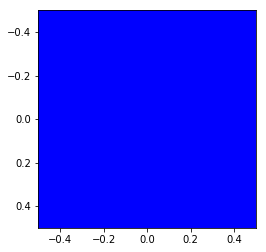

In [116]:
test_image = np.array([
    [[0,0,0]],  
])
test_image.shape

plt.imshow(test_image)

In [132]:
kkk = kkk / 256

In [133]:
kkkk = kkk[:,:,0] * 0.2989 + kkk[:,:,1] * 0.5870 + kkk[:,:,2] * 0.1140

In [140]:
frame = env.physics.render(camera_id=0, height = 48, width = 64)

In [141]:
frame.shape

(48, 64, 3)

In [142]:
frame = frame / 256.0
frame = frame[:,:,[0]] * 0.2989 + frame[:,:,[1]] * 0.5870 + frame[:,:,[2]] * 0.1140
frame = np.moveaxis(frame, [0, 1, 2], [1, 2, 0])

In [144]:
frame.shape

(1, 48, 64)

In [134]:
kkkk.shape

(48, 64)

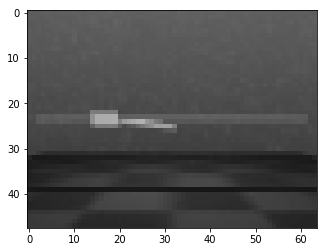

In [145]:
plt.imshow(frame[0], cmap=plt.get_cmap('gray'), vmin=0,vmax=1)

In [ ]:
plt